Start

In [1]:
# Used libraries
import imageio
import numpy as np
import functools
import operator
import itertools
import os
import sys
import matplotlib.pyplot
import random
import cv2

In [2]:
#função que mapeia imagem para um vetor (cromossomo)
def img2chromosome(img):
    #imagem no formato np [width, length, 3] 
    #vetor é preenchido ao longo das linhas da imagem
    cromossomo = np.reshape(img, functools.reduce(operator.mul,img.shape))
    return cromossomo

In [3]:
#criação da população aleatória
def initial_population(img_shape, n_individuals=8):
    """
    Creating an initial population randomly.
    """
    # Inicializando matriz de dimensões N (tamanho da população) x M (dimensão do cromossomo que representa a imagem)
    init_population = np.empty(shape=(n_individuals, functools.reduce(operator.mul, img_shape)),dtype=np.uint8)

    for indv_num in range(n_individuals):
        # Cada celula de cada linha da matriz é preenchida com um valor inteiro aleatório de 0 a 255 (RBG)
        init_population[indv_num, :] = np.random.random(functools.reduce(operator.mul, img_shape))*255
    return init_population

In [4]:
def fitness_fun(target_chrom, indiv_chrom):
    #computa a média das diferenças entre cromossomo original e um cromossomo individual da população
    #erro de cada indivíduo da população é computado em um número 
    quality = np.mean(np.abs(target_chrom - indiv_chrom))

    #qualidade retornada é dada pela soma de todos os valores do cromossomo menos a qualidade medida
    #de forma com que a qualidade aumente quando uma população se torna mais próxima do cromossomo de interesse
    quality = np.sum(target_chrom) - quality
    return quality

In [5]:
def cal_pop_fitness(target_chrom, pop):
    #inicializando vetor que traz os scores de cada população avaliada
    qualities = np.zeros(pop.shape[0])
    #iterando para cada indivíduo da população
    for indv_num in range(pop.shape[0]):
        qualities[indv_num] = fitness_fun(target_chrom, pop[indv_num, :])
    return qualities

In [6]:
def select_mating_pool(pop, qualities, num_parents):
    """
    Selects the best individuals in the current generation, according to the 
    number of parents specified, for mating and generating a new better population.
    """
    
    parents = np.empty((num_parents, pop.shape[1]), dtype=np.uint8)
    for parent_num in range(num_parents):
        # Retrieving the best unselected solution.
        max_qual_idx = np.where(qualities == np.max(qualities))
        max_qual_idx = max_qual_idx[0][0]
        # Appending the currently selected 
        parents[parent_num, :] = pop[max_qual_idx, :]
        """
        Set quality of selected individual to a negative value to not get 
        selected again. Algorithm calcululations will just make qualities >= 0.
        """
        qualities[max_qual_idx] = -1
    return parents

In [7]:
def crossover(parents, img_shape, n_individuals=8):
    new_population = np.empty(shape=(n_individuals, functools.reduce(operator.mul, img_shape)), dtype=np.uint8)
    
    #Previous parents (best elements).
    new_population[0:parents.shape[0], :] = parents
 
    # Getting how many offspring to be generated. If the population size is 8 and number of parents mating is 4, then number of offspring to be generated is 4.
    num_newly_generated = n_individuals-parents.shape[0]
    # Getting all possible permutations of the selected parents.
    parents_permutations = list(itertools.permutations(iterable=np.arange(0, parents.shape[0]), r=2))
    # Randomly selecting the parents permutations to generate the offspring.
    selected_permutations = random.sample(range(len(parents_permutations)), 
                                          num_newly_generated)
    
    comb_idx = parents.shape[0]
    for comb in range(len(selected_permutations)):
        # Generating the offspring using the permutations previously selected randmly.
        selected_comb_idx = selected_permutations[comb]
        selected_comb = parents_permutations[selected_comb_idx]
        
        # Applying crossover by exchanging half of the genes between two parents.
        half_size = np.int32(new_population.shape[1]/2)
        new_population[comb_idx+comb, 0:half_size] = parents[selected_comb[0], 
                                                             0:half_size]
        new_population[comb_idx+comb, half_size:] =  parents[selected_comb[1], 
                                                             half_size:]
    
    return new_population

In [8]:
def mutation(population, num_parents_mating, mut_percent):

    for idx in range(num_parents_mating, population.shape[0]):
        # A predefined percent of genes are selected randomly.
        rand_idx = np.uint32(np.random.random(size=np.uint32(mut_percent/100*population.shape[1]))*population.shape[1])
        # Changing the values of the selected genes randomly.
        new_values = np.uint8(np.random.random(size=rand_idx.shape[0])*256)
        # Updating population after mutation.
        population[idx, rand_idx] = new_values

    return population

In [9]:
def show_indivs(individuals, im_shape):
    """
    Show all individuals as image in a single graph.
    """
    num_ind = individuals.shape[0]
    fig_row_col = 1
    for k in range(1, np.uint16(individuals.shape[0]/2)):
        if np.floor(np.power(k, 2)/num_ind) == 1:
            fig_row_col = k
            break
    fig1, axis1 = matplotlib.pyplot.subplots(fig_row_col, fig_row_col)

    curr_ind = 0
    for idx_r in range(fig_row_col):
        for idx_c in range(fig_row_col):
            if(curr_ind>=individuals.shape[0]):
                break
            else:
                curr_img = chromosome2img(individuals[curr_ind, :], im_shape)
                axis1[idx_r, idx_c].imshow(curr_img)
                curr_ind = curr_ind + 1

In [10]:
def save_images(curr_iteration, qualities, new_population, im_shape, 
                save_point, save_dir):
    """
    Saving best solution in a given generation as an image in the specified directory.
    Images are saved accoirding to stop points to avoid saving images from 
    all generations as saving mang images will make the algorithm slow.
    """
    if(np.mod(curr_iteration, save_point)==0):
        # Selecting best solution (chromosome) in the generation.
        best_solution_chrom = new_population[np.where(qualities == 
                                                         np.max(qualities))[0][0], :]
        # Decoding the selected chromosome to return it back as an image.
        best_solution_img = chromosome2img(best_solution_chrom, im_shape)
        # Saving the image in the specified directory.
        matplotlib.pyplot.imsave(save_dir+'solution_'+str(curr_iteration)+'.png', best_solution_img)

In [11]:
def chromosome2img(chromosome, img_shape):
    """
    First step in GA is to represent the input in a sequence of characters.
    The encoding used is value encoding by giving each gene in the chromosome 
    its actual value.
    """
    img_arr = np.reshape(a=chromosome, newshape=img_shape)
    return img_arr


In [16]:
def geneticAlgorithm():
    #leitura da imagem, em formato np 
    target_im = imageio.imread('apple_low_res.jpg')
    
    # img = cv2.imread('heart.png')
    # target_im = cv2.bilateralFilter(img, 15, 75, 75)
    # cv2.imwrite('heart_2.jpg', target_im)

    target_chromosome = img2chromosome(target_im)
    #Calculando qualidade da população
    # Population size
    sol_per_pop = 8
    # Mating pool size
    num_parents_mating = 4
    # Mutation percentage
    mutation_percent = .01
    
    #Criando população aleatória
    new_population = initial_population(img_shape=target_im.shape, n_individuals=sol_per_pop)

    n_gen = 10000

    for iteration in range(n_gen):
        # Measing the fitness of each chromosome in the population.
        qualities = cal_pop_fitness(target_chromosome, new_population)
        print('Quality : ', np.max(qualities), ', Iteration : ', iteration)
        # Selecting the best parents in the population for mating.
        parents = select_mating_pool(new_population, qualities,
                                        num_parents_mating)

        # Generating next generation using crossover
        new_population = crossover(parents, target_im.shape,

                                        n_individuals=sol_per_pop)

    

        """

        Applying mutation for offspring.

        Mutation is important to avoid local maxima. Avoiding mutation makes

        the GA falls into local maxima.

        Also mutation is important as it adds some little changes to the offspring.

        If the previous parents have some common degaradation, mutation can fix it.

        Increasing mutation percentage will degarde next generations.

        """

        new_population = mutation(population=new_population,

                                    num_parents_mating=num_parents_mating,

                                    mut_percent=mutation_percent)

        """

        Save best individual in the generation as an image for later visualization.

        """

        save_images(iteration, qualities, new_population, target_im.shape,

                        save_point=500, save_dir=os.curdir+'//')
                        
    # Display the final generation
    show_indivs(new_population, target_im.shape)

Quality :  29882360.642159864 , Iteration :  0
Quality :  29882360.77973923 , Iteration :  1
Quality :  29882360.77973923 , Iteration :  2
Quality :  29882360.783015873 , Iteration :  3
Quality :  29882360.783015873 , Iteration :  4
Quality :  29882360.783956915 , Iteration :  5
Quality :  29882360.78548186 , Iteration :  6
Quality :  29882360.78973356 , Iteration :  7
Quality :  29882360.78973356 , Iteration :  8
Quality :  29882360.78973356 , Iteration :  9
Quality :  29882360.795867346 , Iteration :  10
Quality :  29882360.795867346 , Iteration :  11
Quality :  29882360.795867346 , Iteration :  12
Quality :  29882360.799518142 , Iteration :  13
Quality :  29882360.801479593 , Iteration :  14
Quality :  29882360.801479593 , Iteration :  15
Quality :  29882360.808701813 , Iteration :  16
Quality :  29882360.809977323 , Iteration :  17
Quality :  29882360.809977323 , Iteration :  18
Quality :  29882360.809977323 , Iteration :  19
Quality :  29882360.811842404 , Iteration :  20
Quality 

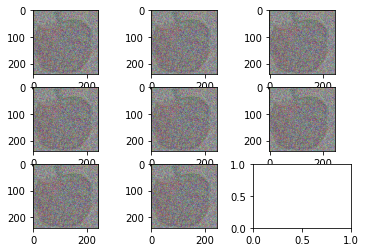

In [18]:
# POPULAÇÃO 100 - Quality :  29882379.74361111 , Iteration :  9999
# POPULAÇÃO   8 - Quality :  29882374.45531746 , Iteration :  9999

geneticAlgorithm()

### FINAL PROJECT

##### READ THE IMAGE

In [14]:
target_im = imageio.imread('apple_low_res.jpg')
target_im = np.asarray(target_im/255, dtype=np.float64)

##### HELPER FUNCTION

In [15]:
def loadImage(filename):
    return imageio.imread(filename)

def saveImage(img, filename):
    imageio.imwrite(filename, img)

def imageToChromosome(imgageArray):
    return np.reshape(a=imgageArray, newshape=(functools.reduce(operator.mul, imgageArray.shape)))


def chromosomeToImage(chromosome, imageShape):
    return np.reshape(a= chromosome, newshape=imageShape)

def removeColorFromImageChromossome(chromossome, color):
    print(chromossome[1])

    for i in range(len(chromossome)):
        if i < len(chromossome)/2:
            chromossome[i] = [0, 0, 255]

    return chromossome

##### GENETIC ALGORITHM FUNCTIONS

##### MAIN